In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
from data import *
from DCshallow import *
from SGDtraining import *

# California Housing Data Set
For more details of this dataset, please refer to [California Housing](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html). The dataset here has already been processed by imputing missing values with medians, the result is stored in a `pandas` dataframe. Also, for the purpose of training, we standardize all numerical variables, and use one-hot encoding for categorical variables, and put all predictors in *X* (with the first column all-one vector) and reponse in *Y*. To get them, call `load_calhousing()`

In [3]:
calhousing = load_calhousing()
# dataframe
calhousing_df = calhousing["calhousing_df"]
# predictors
X = calhousing["X"]
# response
Y = calhousing["Y"]

In [4]:
calhousing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
calhousing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
calhousing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,536.838857,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,419.391878,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,297.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,643.250000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


<Figure size 432x288 with 0 Axes>

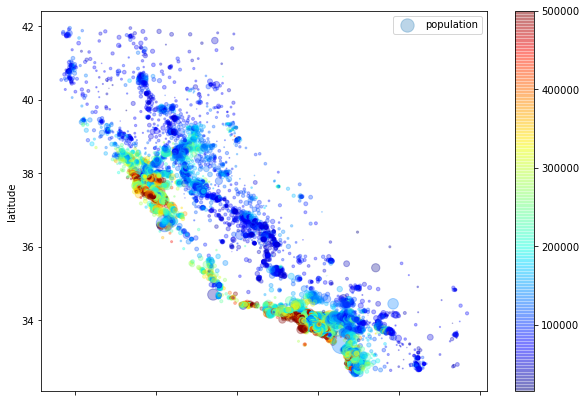

In [7]:
plt.figure()
calhousing_df.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.3,
         s = calhousing_df['population'] / 100, label = 'population',   # set symbol size on population
         c = calhousing_df['median_house_value'],                  #  set symbol color on house value    
         cmap = plt.get_cmap('jet'),      
         colorbar = True,
         figsize = (10,7))
plt.legend()

In [8]:
X[0:5, 0:5]

array([[ 1.        , -1.32783522,  1.05254828,  0.98214266, -0.8048191 ],
       [ 1.        , -1.32284391,  1.04318455, -0.60701891,  2.0458901 ],
       [ 1.        , -1.33282653,  1.03850269,  1.85618152, -0.53574589],
       [ 1.        , -1.33781784,  1.03850269,  1.85618152, -0.62421459],
       [ 1.        , -1.33781784,  1.03850269,  1.85618152, -0.46240395]])

In [9]:
Y

array([[ 2.12963148],
       [ 1.31415614],
       [ 1.25869341],
       ...,
       [-0.99274649],
       [-1.05860847],
       [-1.01787803]])

# SGD Training 
This section uses a toy example with shallow ReLU network structure to illustrate some basic usages of function `trainnn_sgd()`.

In [10]:
# size of the problem
n = 100 # sample size
p = 5 # number of features
width =10 # number of neurons
sigma = 0.1 # noise level
train_pct = 0.8 # proportion of training samples
train_size = int(n * train_pct)
val_size = n - train_size

# true underlying nn model
truemodel = torch.nn.Sequential(
    torch.nn.Linear(p, width, bias = False),
    torch.nn.ReLU(),
    torch.nn.Linear(width, 1, bias = False),
    torch.nn.Flatten(0, 1)
)

# prepare dataset, dataloaders for model training
dataset = normal_nn(n, p, truemodel, sigma)
train_ds, val_ds = splitdataset(dataset, train_pct = train_pct)   

In [11]:
# use the same structure to define training model
train_model = torch.nn.Sequential(
    torch.nn.Linear(p, width, bias = False),
    torch.nn.ReLU(),
    torch.nn.Linear(width, 1, bias = False),
    torch.nn.Flatten(0, 1)
)
batch_size = 10

In [12]:
print("\nstart SGD training with learning rate 0.1 for 10 epochs")
train_loss, val_loss, train_model = trainnn_sgd(train_ds, val_ds, batch_size, train_model, lr = 0.1, loss_fn = torch.nn.L1Loss(), nepochs = 10, show = 1)


start SGD training with learning rate 0.1 for 10 epochs
epoch: 0 ; training error: 0.29576594 ; prediction error: 0.32174757
epoch: 1 ; training error: 0.22142236 ; prediction error: 0.24613778
epoch: 2 ; training error: 0.19202131 ; prediction error: 0.20802672
epoch: 3 ; training error: 0.17836480 ; prediction error: 0.16950437
epoch: 4 ; training error: 0.16835503 ; prediction error: 0.15742879
epoch: 5 ; training error: 0.15991589 ; prediction error: 0.14589116
epoch: 6 ; training error: 0.15335153 ; prediction error: 0.12804466
epoch: 7 ; training error: 0.14795347 ; prediction error: 0.11622874
epoch: 8 ; training error: 0.14522539 ; prediction error: 0.11557567
epoch: 9 ; training error: 0.14040965 ; prediction error: 0.11554384
epoch: 10 ; training error: 0.13432871 ; prediction error: 0.11225335


One advantage of this function is that the returned trained model `train_model` can be reused for the next round of training, maybe with a smaller learning rate:

In [13]:
print("\nstart SGD training for the second round with learning rate 0.01 for another 10 epochs")
train_loss2, val_loss2, train_model = trainnn_sgd(train_ds, val_ds, batch_size, train_model, lr = 0.01, loss_fn = torch.nn.L1Loss(), nepochs = 10, show = 1)


start SGD training for the second round with learning rate 0.01 for another 10 epochs
epoch: 0 ; training error: 0.13432871 ; prediction error: 0.11225335
epoch: 1 ; training error: 0.13296013 ; prediction error: 0.11212325
epoch: 2 ; training error: 0.13172522 ; prediction error: 0.11191064
epoch: 3 ; training error: 0.13069926 ; prediction error: 0.11149786
epoch: 4 ; training error: 0.12969868 ; prediction error: 0.11092554
epoch: 5 ; training error: 0.12863354 ; prediction error: 0.11028727
epoch: 6 ; training error: 0.12778945 ; prediction error: 0.11186664
epoch: 7 ; training error: 0.12662360 ; prediction error: 0.11148290
epoch: 8 ; training error: 0.12594780 ; prediction error: 0.11149013
epoch: 9 ; training error: 0.12490401 ; prediction error: 0.11188787
epoch: 10 ; training error: 0.12431601 ; prediction error: 0.11195846


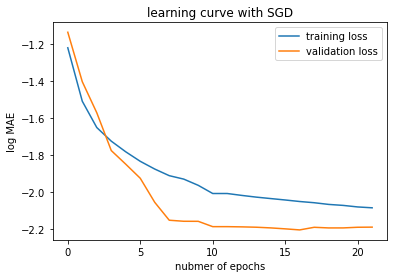

In [14]:
# combine them together
train_loss = train_loss + train_loss2
val_loss = val_loss + val_loss2

# learning curve
plt.figure()
plt.plot(np.log(train_loss), label = 'training loss')
plt.plot(np.log(val_loss), label = 'validation loss')
plt.xlabel('nubmer of epochs')
plt.ylabel('log MAE')
plt.title('learning curve with SGD')
plt.legend(loc = "best")

# One-Pass DC Algorithm
This section illustrates the usage of function `trainnn_dcshallow()` for shallow ReLU neural networks. The DC training will start from the solution pretrained by SGD. The problem setup are the same as in SGD training.

In [15]:
# train shallow NN with DC algorithm
print("\n strat DC training for 10 iterations with lambda = 10.0")
U0, alpha0, train_dcloss, val_dcloss, exactpenalty = trainnn_dcshallow(train_ds, val_ds, width, train_model, iterations = 10)


 strat DC training for 10 iterations with lambda = 10.0
DC iteration: 0 ; training error: 0.12431601 ; prediction error: 0.11195845
DC iteration: 1 ; training error: 0.12003136 ; prediction error: 0.11226550
DC iteration: 2 ; training error: 0.11664812 ; prediction error: 0.11155236
DC iteration: 3 ; training error: 0.11361273 ; prediction error: 0.11180473
DC iteration: 4 ; training error: 0.11044416 ; prediction error: 0.11101487
DC iteration: 5 ; training error: 0.10770489 ; prediction error: 0.11115102
DC iteration: 6 ; training error: 0.10510054 ; prediction error: 0.11256653
DC iteration: 7 ; training error: 0.10233651 ; prediction error: 0.11400138
DC iteration: 8 ; training error: 0.09982976 ; prediction error: 0.11408336
DC iteration: 9 ; training error: 0.09719664 ; prediction error: 0.11291277
DC iteration: 10 ; training error: 0.09440453 ; prediction error: 0.11166823


In [16]:
print(exactpenalty)

6.4613917230153595e-06


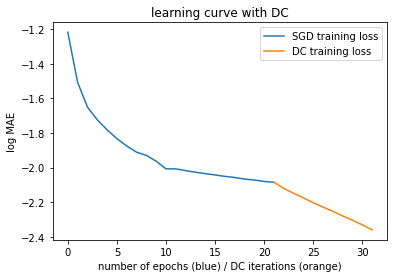

In [17]:
# plots
first = len(train_loss)
second = len(train_dcloss)
plt.figure()
plt.plot(np.log(train_loss), label = 'SGD training loss')
plt.plot(first + np.array(range(second)) - 1, np.log(train_dcloss), label = 'DC training loss')
plt.xlabel('number of epochs (blue) / DC iterations (orange)')
plt.ylabel('log MAE')
plt.title('learning curve with DC')
plt.legend(loc = "best")